This notebook analyzes scaling laws when learning on top of frozen embeddings.

It is meant to serve as the prototype of an eventual wandb script.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import sys
from typing import Any

import cuml.decomposition
import cuml.manifold.umap
import cuml.neighbors.kneighbors_classifier
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import gen_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import imagenette, svhn
from src.pretrain.models.vision import laion_clip
from src.pretrain.probes import linear_probe, knn_probe

### Load data

In [3]:
# dataset_cfg = svhn.SVHN()
dataset_cfg = imagenette.Imagenette()
embedder_cfg = laion_clip.LaionClipConfig()

embedding_cfg = gen_embeddings.Config(
    dataset_cfg=dataset_cfg,
    embedder_cfg=embedder_cfg,
)

DS = EmbeddingDataset.load_from_file(embedding_cfg.full_save_path)
DS.xs_train.shape, DS.xs_test.shape

((9469, 1280), (3925, 1280))

### Dataset info

Text(0.5, 0, 'Class')

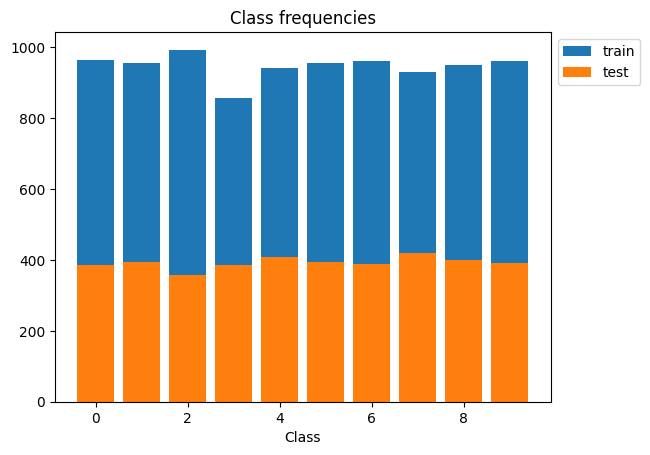

In [107]:
# Get frequencies of each class in the training set
train_class_freqs = np.bincount(DS.ys_train)
plt.bar(np.arange(len(train_class_freqs)), train_class_freqs, label="train")

# Get frequencies of each class in the test set
test_class_freqs = np.bincount(DS.ys_test)
plt.bar(np.arange(len(test_class_freqs)), test_class_freqs, label="test")

# Legend on outside top right
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Class frequencies")
plt.xlabel("Class")

### Visualize embeddings with UMAP

In [5]:
# min_dist = 0.1
# n_neighbors = 10
# red = umap.UMAP(
#     n_components=2,
#     min_dist=min_dist,
#     n_neighbors=n_neighbors,
#     random_state=0,
# )

# xs_test_2d = red.fit_transform(DS.xs_test)

In [6]:
min_dist = 0.1
n_neighbors = 10

# xs_train_2d = cuml.manifold.umap.UMAP(
#     n_components=2,
#     min_dist=min_dist,
#     n_neighbors=n_neighbors,
#     random_state=0,
# ).fit_transform(DS.xs_train)

xs_test_2d = cuml.manifold.umap.UMAP(
    n_components=2,
    min_dist=min_dist,
    n_neighbors=n_neighbors,
    random_state=0,
).fit_transform(DS.xs_test)

In [ ]:
# Visualize xs_test_2d in plotly
df = pd.DataFrame(
    {
        "x": xs_test_2d[:, 0],
        "y": xs_test_2d[:, 1],
        "class": DS.ys_test,
        "class_name": [dataset_cfg.class_names[c] for c in DS.ys_test],
    }
)

fig = px.scatter(
    df.sort_values("class"),
    x="x",
    y="y",
    color="class_name",
    title=f"UMAP of test set ({min_dist=}, {n_neighbors=})",
    labels={"class_name": "Class"},
    width=800,
    height=500,
)

# Make alpha 0.5
fig.update_traces(marker=dict(opacity=0.8))

fig.show()

### Visualize embeddings with PCA

In [7]:
pca = cuml.decomposition.PCA(n_components=3, whiten=True)
components = pca.fit_transform(DS.xs_test)

In [ ]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(3),
    color=[dataset_cfg.class_names[c] for c in DS.ys_test],
    width=700,
    height=600,
)
# Make marker size smaller
fig.update_traces(
    diagonal_visible=False,
    marker=dict(opacity=0.8, size=3),
)
fig.update_layout(legend=dict(itemsizing="constant"))
fig.show()

### Measure scaling laws

In [9]:
def measure_scaling(
    ds: EmbeddingDataset,
    per_class: bool,
    ks: tuple[int, ...] = (1, 3, 10),
    cs: tuple[float, ...] = (0.01, 1, 100),
    use_gpu: bool = True,
) -> list[dict[str, Any]]:
    def gen_n_trains():
        base = 1
        while True:
            for i in range(1, 10):
                yield base * i
            base *= 10

    results = []

    mx_n_train = ds.min_samples_per_class if per_class else len(ds.xs_train)
    for n_train in gen_n_trains():
        if n_train > mx_n_train:
            n_train = mx_n_train

        sub_ds = (
            ds.subsample_per_class(n_train_per_class=n_train)
            if per_class
            else ds.subsample(n_train=n_train)
        )

        # k-NN probe experiments
        for k in ks:
            if k >= len(sub_ds.xs_train):
                continue
            results.append(
                knn_probe.run_experiment(
                    ds=sub_ds,
                    k=k,
                    metric="euclidean",
                    use_gpu=use_gpu,
                )
                | dict(n_train=n_train, per_class=per_class, probe="knn")
            )
        
        # linear probe experiments
        for c in cs:
            results.append(
                linear_probe.run_experiment(
                    ds=sub_ds,
                    c=c,
                    use_gpu=use_gpu,
                )
                | dict(n_train=n_train, per_class=per_class, probe="linear")
            )

        if n_train == mx_n_train:
            break

    return results

In [10]:
DATA = []
tot_classes = DS.n_classes
for n_classes in tqdm([2, 5, 10]):
    for i in range(10):
        cls_start = i * n_classes
        cls_end = cls_start + n_classes
        if cls_end > tot_classes:
            break

        cds = DS.filter_classes(range(cls_start, cls_end))

        for per_class in [False, True]:
            DATA.extend(
                [
                    d | dict(cls_start=cls_start, cls_end=cls_end)
                    for d in measure_scaling(ds=cds, per_class=per_class)
                ]
            )

  0%|          | 0/3 [00:00<?, ?it/s]

[W] [22:15:05.524267] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:06.538668] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:18: RuntimeWarning: divide by zero encountered in log
  logits_test = np.log(probs_test)
/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:17: RuntimeWarning: divide by zero encountered in log
  logits_train = np.log(probs_train)
/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:21: RuntimeWarning: invalid value encountered in multiply
  alogits = alpha * logits_train


[W] [22:15:08.828970] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:11.847118] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:13.236213] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:14.603884] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:15.446768] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:21.983573] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:23.057855] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:23.333078] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:23.374993] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


 33%|███▎      | 1/3 [00:27<00:55, 27.64s/it]

[W] [22:15:33.398322] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:33.524762] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:34.788058] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:34.866528] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:35.834405] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:35.958502] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:37.679349] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:38.859864] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:42.513945] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:46.494596] L-BFGS stopped, because the line search fa

 67%|██████▋   | 2/3 [00:47<00:22, 22.88s/it]

[W] [22:15:53.261552] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:53.624981] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:53.702178] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:53.814813] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:54.157120] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:54.693596] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:54.892198] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:56.518929] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


/home/gridsan/twang/code/scaling/src/pretrain/probes/linear_probe.py:28: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()


[W] [22:15:58.339789] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:15:59.499507] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:00.904737] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:01.816939] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:02.653682] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:03.653554] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:04.047865] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:04.096377] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:04.176957] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [22:16:04.537358] L-BFGS stopped, because the line search fa

100%|██████████| 3/3 [01:04<00:00, 21.52s/it]


In [11]:
df = pd.DataFrame(DATA)
df["err"] = 1 - df.acc
df["hyper"] = ""
df.loc[df.probe == "linear" , "hyper"] = "c=" + df[df.probe == "linear"].c.astype(str)
df.loc[df.probe == "knn" , "hyper"] = "k=" + df[df.probe == "knn"].k.astype(str)
df

,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,cls_end,k,metric,err,hyper
0,0.01,10000.0,0.0,True,0.494885,inf,1,False,linear,0,2,NaN,NaN,0.505115,c=0.01
1,1.00,10000.0,0.0,True,0.494885,inf,1,False,linear,0,2,NaN,NaN,0.505115,c=1.0
2,100.00,10000.0,0.0,True,0.494885,inf,1,False,linear,0,2,NaN,NaN,0.505115,c=100.0
3,NaN,NaN,NaN,True,0.505115,NaN,2,False,knn,0,2,1.0,euclidean,0.494885,k=1.0
4,0.01,10000.0,0.0,True,0.505115,inf,2,False,linear,0,2,NaN,NaN,0.494885,c=0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,NaN,NaN,NaN,True,0.995669,NaN,858,True,knn,0,10,3.0,euclidean,0.004331,k=3.0
2651,NaN,NaN,NaN,True,0.995924,NaN,858,True,knn,0,10,10.0,euclidean,0.004076,k=10.0
2652,0.01,10000.0,0.0,True,0.997962,inf,858,True,linear,0,10,NaN,NaN,0.002038,c=0.01
2653,1.00,10000.0,0.0,True,0.997707,0.072244,858,True,linear,0,10,NaN,NaN,0.002293,c=1.0


### Plot scaling laws

In [93]:
for per_class in [False, True]:
    for n_classes in [2, 5, 10]:
        for i in range(10):
            cls_start = i * n_classes
            cls_end = cls_start + n_classes
            if cls_end > tot_classes:
                break

            cdf = df.query(
                "&".join(
                    [
                        f"cls_start == {cls_start}",
                        f"cls_end == {cls_end}",
                        f"per_class == {per_class}",
                    ]
                )
            ).copy().sort_values(by=["probe", "n_train"], ascending=[False, True])

            min_err = 1 / cdf.n_train.max()
            cdf.loc[cdf.err == 0, "err"] = min_err / 10

            # Solid line for linear probe
            fig = px.line(
                cdf,
                x="n_train",
                y="err",
                color="hyper",
                line_dash="probe",
                title=f"# classes = {n_classes} ({cls_start} to {cls_end - 1})",
            )

            # Draw horizontal line for min nonzero error, behind all other lines
            # Make color black
            fig.add_scatter(
                x=[1, cdf.n_train.max()],
                y=[min_err, min_err],
                name="1 / max_n_train",
                line_dash="dash",
                line_color="black",
            )

            # Reorder lines
            fig.data = fig.data[-1:] + fig.data[:-1]

            # Update axes
            fig.update_xaxes(
                title_text="Train samples / class"
                if per_class
                else "Total train samples",
                type="log",
            )
            fig.update_yaxes(
                type="log",
                range=[np.log10(min_err / 20), 0],
            )

            # Set height and width
            fig.update_layout(width=500, height=300)

            # Decrease margins
            fig.update_layout(margin=dict(l=20, r=20, t=40, b=20))

            fig.show()
